# PESTPP-GLM

In this notebook, we will run PESTPP-GLM in standard parameter estimation mode and regularization mode.  In both cases, we will use the baked-in bayes-linear posterior monte carlo analysis to get posterior forecast PDFs.  We will use the prior monte carlo outputs as the prior forecast PDF.

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.size']=12
import flopy
import pyemu


flopy is installed in /Users/jeremyw/Dev/gw1876/activities_2day_mfm/notebooks/flopy


In [2]:
t_d = "template"
m_d = "master_glm"

In [3]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
strk,strk,log,40,0,2,-2,1
cn_sy8,cn_sy8,log,1,0,0.243038,-0.60206,0.211275
gr_ss4,gr_ss4,log,705,0,1,-1,0.5
gr_ss3,gr_ss3,log,705,0,1,-1,0.5
pp_vka2,pp_vka2,log,32,0,1,-1,0.5
cn_strt7,cn_strt7,log,1,0,0.0211893,-0.0222764,0.0108664
gr_rech3,gr_rech3,log,705,0,0.0413927,-0.0457575,0.0217875
cn_prsity7,cn_prsity7,log,1,0,0,-1,0.25
gr_prsity3,gr_prsity3,log,705,0,0,-1,0.25
cn_rech4,cn_rech4,log,1,0,0.0791812,-0.09691,0.0440228


### reduce the number of adjustable parameters

This is the painful part: we cant use 10K+ pars because we cant wait around for that many runs and then the linear algebra of factoring a 10k+ by 10K+ matrix is also difficult.  So that means we need to fix a lot a parameters #frownyface

In [4]:
par = pst.parameter_data

In [5]:
# grid-scale pars
gr_pars = par.loc[par.pargp.apply(lambda x: "gr" in x),"parnme"]
par.loc[gr_pars,"partrans"] = "fixed"
pst.npar_adj

719

In [6]:
# these are the sfr conductance parameters - Ive left all 40 adjustable
# but if you uncomment this, it will tie them into 1 parameter effectively
# strk_pars = par.loc[par.pargp=="strk","parnme"]
# p1 = strk_pars.iloc[0]
# par.loc[strk_pars.iloc[1:],"partrans"] = "tied"
# par.loc[strk_pars.iloc[1:],"partied"] = p1
pst.npar_adj

719

In [7]:
par.loc[par.pargp.apply(lambda x: "pp" in x),"pargp"].unique()

array(['pp_hk0', 'pp_hk1', 'pp_hk2', 'pp_prsity0', 'pp_prsity1',
       'pp_prsity2', 'pp_rech0', 'pp_rech1', 'pp_ss0', 'pp_ss1', 'pp_ss2',
       'pp_strt0', 'pp_strt1', 'pp_strt2', 'pp_sy0', 'pp_sy1', 'pp_sy2',
       'pp_vka0', 'pp_vka1', 'pp_vka2'], dtype=object)

Fix the storage pilot points - we still have layer-scale storage pars adjustable

In [8]:
#s_pars = par.loc[par.pargp.apply(lambda x: "pp" in x and ("ss" in x or "sy" in x)),"parnme"]
#par.loc[s_pars,"partrans"] = "fixed"
pst.npar_adj

719

In [9]:
adj_par = par.loc[par.partrans=="log",:]
adj_par.pargp.value_counts().sort_values()

cn_sy8          1
cn_strt6        1
cn_hk7          1
cn_rech4        1
cn_rech5        1
cn_hk6          1
cn_strt7        1
cn_prsity8      1
cn_ss7          1
cn_prsity6      1
cn_vka6         1
cn_ss8          1
cn_hk8          1
cn_prsity7      1
cn_vka8         1
cn_sy7          1
cn_strt8        1
cn_ss6          1
cn_vka7         1
cn_sy6          1
flow            1
welflux         2
welflux_k02     6
drncond_k00    10
pp_hk0         32
pp_sy1         32
pp_vka1        32
pp_strt2       32
pp_ss2         32
pp_prsity2     32
pp_ss1         32
pp_sy0         32
pp_sy2         32
pp_hk2         32
pp_hk1         32
pp_strt0       32
pp_vka0        32
pp_rech0       32
pp_strt1       32
pp_vka2        32
pp_prsity0     32
pp_rech1       32
pp_ss0         32
pp_prsity1     32
strk           40
Name: pargp, dtype: int64

fix the future recharge pilot points, vka in layers 1 and 3 and the initial condition pilot points (we still have layer-scale pars for each of these types)

In [10]:
fi_grps = ["pp_rech1","pp_vka0","pp_vka2","pp_strt0","pp_strt1","pp_strt2"]
par.loc[par.pargp.apply(lambda x: x in fi_grps),"partrans"] = "fixed"
pst.npar_adj

527

Ok, thats better...so lets run PESTPP-GLM.  We will use a single "base parameter" jacobian matrix as the basis for 6 super parameter iterations.  Then we will draw 100 realizations from the FOSM posterior parameter covariance matrix and run those 100 realizations to get the psoterior forecast PDFs

In [11]:
pst.control_data.noptmax = 3
pst.pestpp_options["n_iter_base"] = -1
pst.pestpp_options["n_iter_super"] = 3
pst.pestpp_options["num_reals"] = 50 # this is how many ies uses
pst.pestpp_options["parcov"] = "prior_cov.jcb"
pst.write(os.path.join(t_d,"freyberg_pp.pst"))

In [12]:
pyemu.os_utils.start_slaves(t_d,"pestpp-glm","freyberg_pp.pst",num_slaves=20,slave_root=".",
                           master_dir=m_d)

In [13]:
df = df=pd.read_csv(os.path.join(m_d,"freyberg_pp.post.obsen.csv"),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

real_name
40     300.402885
45     555.407952
6      697.909767
9      717.298349
11     782.518726
20     905.929630
42     936.951440
21     979.176592
49    1188.282724
41    1956.268550
25    2165.826653
22    3247.541258
1     3382.082289
39    3890.602707
24    3939.673160
33    3942.549541
8     4024.830575
15    4408.586314
35    4425.374021
29    4828.066923
dtype: float64

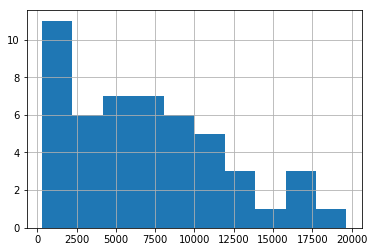

In [14]:
ax = oe.phi_vector.hist()#bins=np.linspace(0,100,20))
oe.phi_vector.sort_values().iloc[:20]

Here we see the distribution of phi values across the 100 posterior realizations.  Should we accept all of these???  The theoretical phi we should accept is number of nonzero obs (14).

To get a "posterior" ensemble, we need to throw out the realizations with large phi - lets just take the 20 best:

In [15]:
oe_pt = oe.loc[oe.phi_vector.sort_values().index[:20],:] #just take the 20 lowest phi realizations

We can also load and plot the FOSM forecast results along side of the ensemble results:

In [16]:
f_df = pd.read_csv(os.path.join(m_d,"freyberg_pp.pred.usum.csv"),index_col=0)
f_df.index = f_df.index.map(str.lower)
f_df

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
fa_hw_19791230,-977.2390,295.32800,-1567.8900,-386.5840,-1507.1700,247.835000,-2002.8500,-1011.5000
fa_hw_19801229,-351.2160,409.77000,-1170.7600,468.3240,-547.7180,335.549000,-1218.8200,123.3800
fa_tw_19791230,-453.0330,409.35100,-1271.7400,365.6690,-993.5230,170.577000,-1334.6800,-652.3690
fa_tw_19801229,108.9600,506.73200,-904.5040,1122.4200,199.5300,263.671000,-327.8120,726.8720
hds_00_013_002_000,39.6102,3.96314,31.6840,47.5365,44.5738,0.273990,44.0258,45.1218
hds_00_013_002_001,38.3838,4.05782,30.2681,46.4994,41.0369,0.687833,39.6612,42.4125
part_status,2.0000,0.00000,2.0000,2.0000,2.0000,0.000000,2.0000,2.0000
part_time,907.7020,704.75100,-501.8010,2317.2000,1131.0700,601.307000,-71.5422,2333.6900


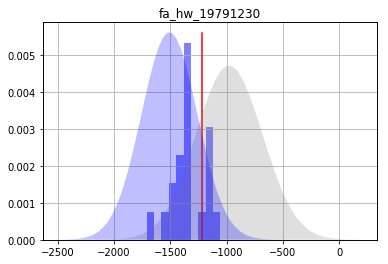

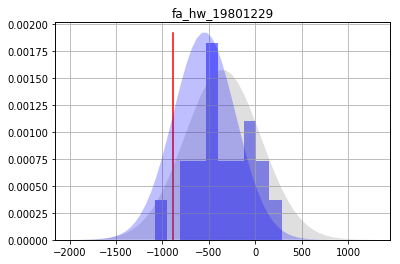

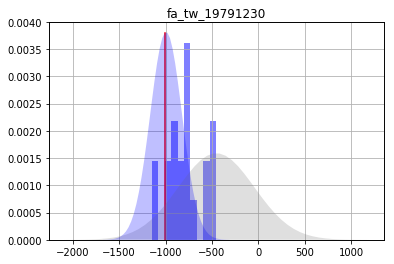

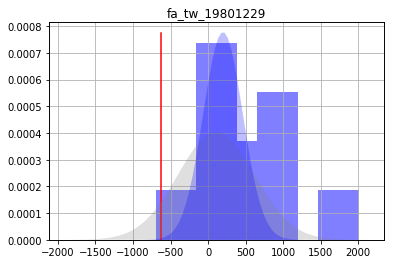

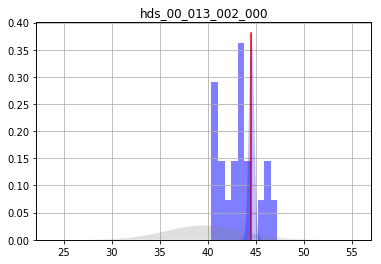

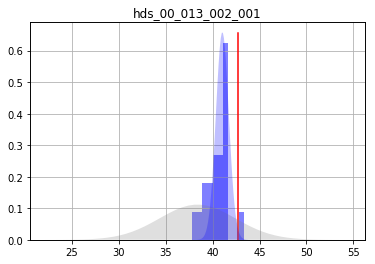

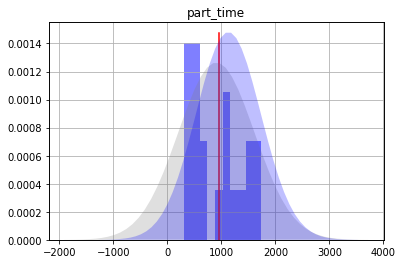

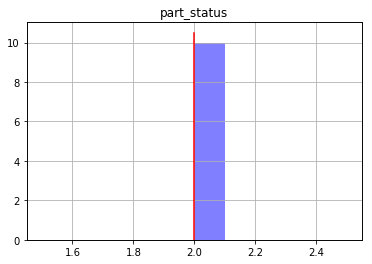

In [17]:
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    ax = plt.subplot(111)
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5,normed=True)
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    axt = plt.twinx()
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"prior_mean"],f_df.loc[forecast,"prior_stdev"])
    axt.fill_between(x,0,y,facecolor="0.5",alpha=0.25)
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"post_mean"],f_df.loc[forecast,"post_stdev"])
    axt.fill_between(x,0,y,facecolor="b",alpha=0.25)
    axt.set_ylim(0,axt.get_ylim()[1])
    axt.set_yticks([])
    ax.set_title(forecast)
    plt.show()

### Setup of Tikhonov regularization

Now lets setup and use some formal regularization to bring the final phi up to around 14.  We will use first-order regularization based on the covariance matrix we build earlier:

In [18]:
cov = pyemu.Cov.from_binary(os.path.join(t_d,"prior_cov.jcb"))

new binary format detected...


In [19]:
pyemu.helpers.first_order_pearson_tikhonov(pst,cov)

getting CC matrix
processing


In [20]:
pst.prior_information.head()

,equation,obgnme,pilbl,weight
pilbl,,,,
pcc_1,1.0 * log(dc0000390005) - 1.0 * log(dc0000390006) = 0.0,regul_cc,pcc_1,0.904837
pcc_2,1.0 * log(dc0000390005) - 1.0 * log(dc0000390007) = 0.0,regul_cc,pcc_2,0.818731
pcc_3,1.0 * log(dc0000390005) - 1.0 * log(dc0000390008) = 0.0,regul_cc,pcc_3,0.740818
pcc_4,1.0 * log(dc0000390005) - 1.0 * log(dc0000390009) = 0.0,regul_cc,pcc_4,0.670320
pcc_5,1.0 * log(dc0000390005) - 1.0 * log(dc0000390010) = 0.0,regul_cc,pcc_5,0.606531


In [21]:
shutil.copy2(os.path.join(m_d,"freyberg_pp.jcb"),os.path.join(t_d,"restart_pp.jcb"))


'template/restart_pp.jcb'

In [22]:
pst.pestpp_options["base_jacobian"] = "restart_pp.jcb"
pst.reg_data.phimlim = pst.nnz_obs
pst.reg_data.phimaccept = pst.reg_data.phimlim * 1.1
pst.write(os.path.join(t_d,"freyberg_pp.pst"))

In [23]:
pyemu.os_utils.start_slaves(t_d,"pestpp-glm","freyberg_pp.pst",num_slaves=20,slave_root=".",
                           master_dir=m_d)

In [24]:
df = df=pd.read_csv(os.path.join(m_d,"freyberg_pp.post.obsen.csv"),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

real_name
45     123.370340
21     397.421709
42     726.315210
11     757.015238
12     760.083645
22     954.707091
6      986.267185
9     1165.488353
24    1255.508405
1     1267.298833
19    1636.716287
40    2396.789452
20    3502.906187
49    3845.532325
47    3915.474869
25    4190.860266
26    4238.373573
41    4349.334208
8     4434.012635
23    4541.078978
dtype: float64

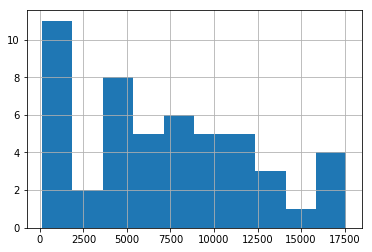

In [25]:
ax = oe.phi_vector.hist()#bins=np.linspace(0,100,20))
oe.phi_vector.sort_values().iloc[:20]

Same as before, to get a "posterior" ensemble, we need to throw out the realizations with large phi - lets just take the 20 best:

In [26]:
oe_pt = oe.loc[oe.phi_vector.sort_values().index[:20],:] 

In [27]:
f_df = pd.read_csv(os.path.join(m_d,"freyberg_pp.pred.usum.csv"),index_col=0)
f_df.index = f_df.index.map(str.lower)
f_df

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
fa_hw_19791230,-977.2390,295.32800,-1567.8900,-386.5840,-1476.8300,247.947000,-1972.7200,-980.9330
fa_hw_19801229,-351.2160,409.77000,-1170.7600,468.3240,-543.4840,336.000000,-1215.4800,128.5170
fa_tw_19791230,-453.0330,409.35100,-1271.7400,365.6690,-974.4930,170.979000,-1316.4500,-632.5340
fa_tw_19801229,108.9600,506.73200,-904.5040,1122.4200,19.0994,263.680000,-508.2600,546.4590
hds_00_013_002_000,39.6102,3.96314,31.6840,47.5365,44.5338,0.274003,43.9858,45.0818
hds_00_013_002_001,38.3838,4.05782,30.2681,46.4994,41.0438,0.687955,39.6678,42.4197
part_status,2.0000,0.00000,2.0000,2.0000,2.0000,0.000000,2.0000,2.0000
part_time,907.7020,704.75100,-501.8010,2317.2000,817.9310,601.413000,-384.8940,2020.7600


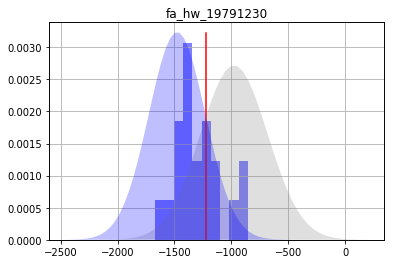

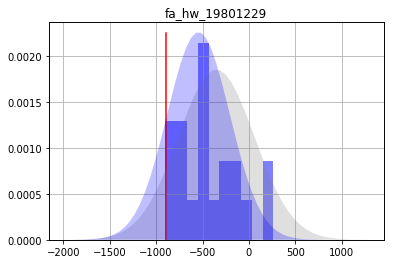

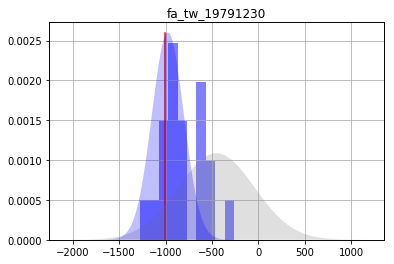

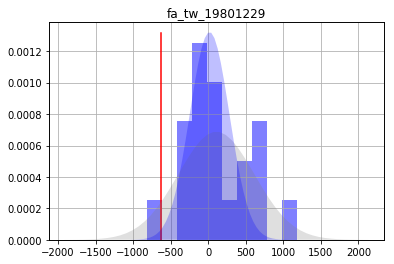

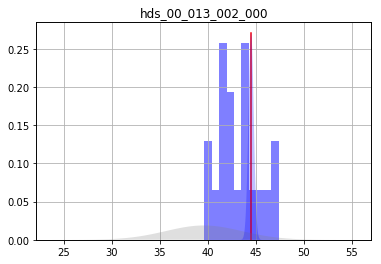

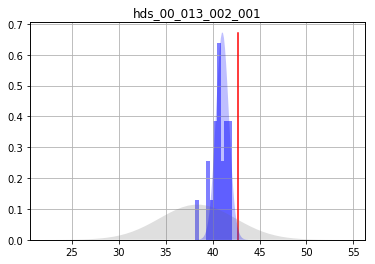

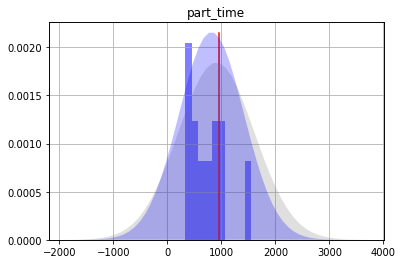

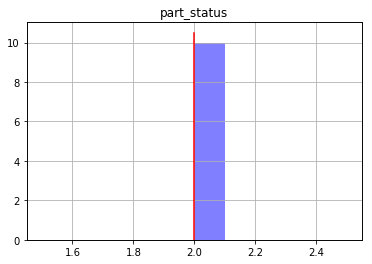

In [28]:
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    ax = plt.subplot(111)
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5,normed=True)
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    axt = plt.twinx()
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"prior_mean"],f_df.loc[forecast,"prior_stdev"])
    axt.fill_between(x,0,y,facecolor="0.5",alpha=0.25)
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"post_mean"],f_df.loc[forecast,"post_stdev"])
    axt.fill_between(x,0,y,facecolor="b",alpha=0.25)
    axt.set_ylim(0,axt.get_ylim()[1])
    axt.set_yticks([])
    ax.set_title(forecast)
    plt.show()